In [1]:
%cd ..

/home/antonbabenko/Projects/newsclass01


In [2]:
%load_ext autoreload
%autoreload 2
%aimport src.model
%aimport src.data
%aimport src.train
%aimport src.eval
%aimport src.utils
%aimport src.metrics

In [3]:
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AdamW, get_linear_schedule_with_warmup

from src.utils import set_seed, load_splits, get_tensorboard_writer
from src.data import TextClassificationDataset
from src.model import TextClassifier
from src.train import fit
from src.eval import eval_nlp
from src.metrics import f1_macro

In [4]:
SEED = 42
MAX_SEQ_LEN = 512
BATCH_SIZE = 8
MODEL_NAME = "youscan/ukr-roberta-base"
EPOCHS = 20

In [5]:
set_seed(SEED)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
logs_dir = Path("logs") 
states_dir = Path("states") / "nlp"
data_dir = Path("data")
folds = Path("folds") / "nlp"
submissions = Path("submissions") / "nlp"

In [8]:
test_df_path = data_dir / "test_without_target.csv"

In [9]:
test_df = pd.read_csv(test_df_path)
test_df.text = test_df.title + " " + test_df.text

In [10]:
splits = load_splits(folds, val_folds=[2], train_folds=[0, 1, 3, 4]) 

In [11]:
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

Loading tokenizer...


In [12]:
tokenizer.sep_token

'</s>'

In [23]:
splits["test"].empty

True

In [24]:
for stage in ["train", "val", "test"]:
    if not stage in splits or splits[stage].empty:
        continue
    splits[stage].text = splits[stage].title + " " + tokenizer.sep_token + " "+ splits[stage].text 

train
val


In [10]:
lengths = []

print('Tokenizing text...')

for sen in splits["train"]["text"]:
    encoded_sent = tokenizer.encode(
        sen,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        #max_length = 512,          # Truncate all sentences.                        
        #return_tensors = 'pt',     # Return pytorch tensors.
   )

    lengths.append(len(encoded_sent))

print('DONE.')

Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


Tokenizing text...
DONE.


In [11]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 28 tokens
   Max length: 16,709 tokens
Median length: 353.0 tokens


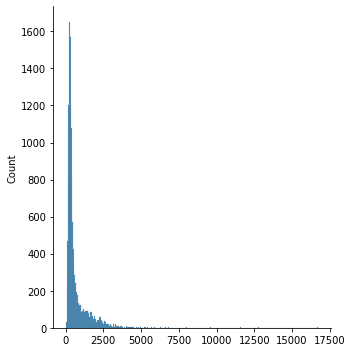

In [12]:
sns.displot(lengths)

/home/antonbabenko/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Text')

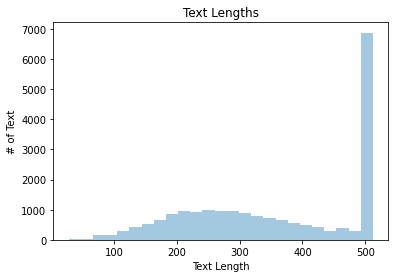

In [13]:
# Truncate any comment lengths greater than 512.
lengths = [min(l, MAX_SEQ_LEN) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('# of Text')

In [14]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(MAX_SEQ_LEN)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

6,598 of 20,293 sentences (32.5%) in the training set are longer than 512 tokens.


In [29]:
train_dataset = TextClassificationDataset(
    texts=splits["train"]["text"].values.tolist(),
    tokenizer=tokenizer,
    labels=splits["train"]["source"].values.tolist(),
    max_seq_length=MAX_SEQ_LEN
)

valid_dataset = TextClassificationDataset(
    texts=splits["val"]["text"].values.tolist(),
    tokenizer=tokenizer,
    labels=splits["val"]["source"].values.tolist(),
    max_seq_length=MAX_SEQ_LEN
)

test_dataset = TextClassificationDataset(
    texts=test_df["text"].values.tolist(),
    tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN
)

In [16]:
# train_dataset = Subset(train_dataset, list(range(16)))
# valid_dataset = Subset(valid_dataset, list(range(16)))
# test_dataset = Subset(test_dataset, 20)

In [30]:
train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [31]:
dataloaders = {
    "train": train_data_loader,
    "val": val_data_loader,
    "test": test_data_loader
}

In [19]:
mini_batch_data = next(iter(val_data_loader))
mini_batch_data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [20]:
print(mini_batch_data['input_ids'].shape)
print(mini_batch_data['attention_mask'].shape)
print(mini_batch_data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


### Model Setup

In [21]:
model = TextClassifier(
    n_classes=splits["train"]["source"].unique().shape[0],
    pretrained_model_name=MODEL_NAME,
    dropout=0.4
).to(device)

### Metrics

In [22]:
metrics = {
    "f1_macro": f1_macro
}

### Tensorboard setup

In [23]:
model_name = f"youscan-ukr-roberta-base-{int(datetime.datetime.now().timestamp())}"
writer = get_tensorboard_writer(logs_dir, model_name) 

In [24]:
optimizer = AdamW([
    {"params": model.bert.parameters(), "lr": 2e-6},
    {"params": model.out.parameters(), "lr": 2e-3}], 
    correct_bias=False
)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss().to(device)

In [25]:
fit(
    model,
    criterion,
    optimizer,
    dataloaders,
    device,
    scheduler=scheduler,
    metrics=metrics,
    epochs=EPOCHS,
    model_name=model_name,
    model_folder=states_dir,
    writer=writer
)

Epoch: 1/20, validation phase: 100%|██████████| 635/635 [01:51<00:00,  5.70it/s]


{'f1_macro': 0.6438724364123349}
Epoch: 1/20, time: 1310.8207890987396 train loss: 0.9258427331552225, val loss: 0.5969075140538694


Epoch: 2/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 2/20, validation phase: 100%|██████████| 635/635 [01:45<00:00,  6.03it/s]


{'f1_macro': 0.7003401929943776}
Epoch: 2/20, time: 1297.099585056305 train loss: 0.4941605611937247, val loss: 0.5777617465720623


Epoch: 3/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 3/20, validation phase: 100%|██████████| 635/635 [01:47<00:00,  5.91it/s]


{'f1_macro': 0.7233214053858645}
Epoch: 3/20, time: 1287.5398833751678 train loss: 0.3788378163254003, val loss: 0.6993032310744391


Epoch: 4/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 4/20, validation phase: 100%|██████████| 635/635 [01:46<00:00,  5.94it/s]


{'f1_macro': 0.7461797581364049}
Epoch: 4/20, time: 1295.665225982666 train loss: 0.3005261421200466, val loss: 0.6926958527919023


Epoch: 5/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 6/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7373652964076576}
Epoch: 5/20, time: 1286.1048662662506 train loss: 0.21202120819262854, val loss: 0.9933860879231174


Epoch: 7/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7389429203059013}
Epoch: 6/20, time: 1229.806327342987 train loss: 0.15505478795218225, val loss: 1.215671914672513


Epoch: 7/20, validation phase: 100%|██████████| 635/635 [01:41<00:00,  6.27it/s]


{'f1_macro': 0.752889650969872}
Epoch: 7/20, time: 1244.6530129909515 train loss: 0.11503808445448968, val loss: 1.248166151488399


Epoch: 8/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 8/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.42it/s]


{'f1_macro': 0.7578911867187687}
Epoch: 8/20, time: 1210.4633340835571 train loss: 0.09070575667211507, val loss: 1.4680640592091059


Epoch: 9/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 9/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.42it/s]


{'f1_macro': 0.7625449198493499}
Epoch: 9/20, time: 1208.321581363678 train loss: 0.06528709716944033, val loss: 1.7307849342190162


Epoch: 10/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 10/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.42it/s]


{'f1_macro': 0.7640657351666464}
Epoch: 10/20, time: 1207.4823405742645 train loss: 0.044119554925533225, val loss: 1.8165443752447705


Epoch: 11/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 12/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7627807134560094}
Epoch: 11/20, time: 1207.29736661911 train loss: 0.03145591487259624, val loss: 2.072068296798533


Epoch: 12/20, validation phase: 100%|██████████| 635/635 [01:39<00:00,  6.41it/s]


{'f1_macro': 0.767065792736725}
Epoch: 12/20, time: 1207.0579311847687 train loss: 0.023989562134906446, val loss: 1.9150661114072294


Epoch: 13/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 13/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.43it/s]


{'f1_macro': 0.7723408412787681}
Epoch: 13/20, time: 1206.538568496704 train loss: 0.0165361936141816, val loss: 1.9410311726086584


Epoch: 14/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 14/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.42it/s]


{'f1_macro': 0.7837475070814934}
Epoch: 14/20, time: 1206.1738398075104 train loss: 0.016198630527740062, val loss: 2.0721805791000616


Epoch: 15/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

Checkpoint was saved


Epoch: 16/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7664355526976179}
Epoch: 15/20, time: 1205.7289850711823 train loss: 0.012846515468251172, val loss: 2.166614218119415


Epoch: 17/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7713694295487367}
Epoch: 16/20, time: 1206.376734495163 train loss: 0.004958903042704974, val loss: 2.3702088570473907


Epoch: 18/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7768639472915297}
Epoch: 17/20, time: 1205.810186624527 train loss: 0.004663723923502882, val loss: 2.228987695099028


Epoch: 19/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7647965563979604}
Epoch: 18/20, time: 1205.9405505657196 train loss: 0.004328340888576757, val loss: 2.3587882998629164


Epoch: 20/20, train phase:   0%|          | 0/2537 [00:00<?, ?it/s]

{'f1_macro': 0.7698360685473945}
Epoch: 19/20, time: 1205.5299739837646 train loss: 0.004243779473278686, val loss: 2.247096513705093


Epoch: 20/20, validation phase: 100%|██████████| 635/635 [01:38<00:00,  6.42it/s]

{'f1_macro': 0.7696235349397875}
Epoch: 20/20, time: 1205.7623386383057 train loss: 0.0027838716342116357, val loss: 2.3020381218193147


## Evaluation

In [44]:
checkpoint_path = states_dir / "epoch-14-youscan-ukr-roberta-base-1616447037-checkpoint.pt"

In [45]:
model = TextClassifier(
    n_classes=splits["train"]["source"].unique().shape[0],
    pretrained_model_name=MODEL_NAME,
    dropout=0.4
)

In [47]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
print("Models have been loaded")

model = model.to(device)

Models have been loaded


In [48]:
predictions, _ = eval_nlp(model, dataloaders["test"], device)

eval phase: 100%|██████████| 2023/2023 [04:50<00:00,  6.97it/s]


In [49]:
test_df["Predicted"] = predictions

In [50]:
submission_df = test_df[["Id", "Predicted"]]

In [51]:
submission_df.to_csv(submissions / f"youscan-roberta-{int(datetime.datetime.now().timestamp())}.csv", index=False)